## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone

Reading CSV:

In [2]:
df=pd.read_csv("train.csv")

First look:

In [3]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,200189,NaN,NaN,NaN,13661,8170.42,500,7500,12000,18700,35000
term,200189,2,36 months,153900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,200189,NaN,NaN,NaN,13.8778,4.42672,5.32,10.99,13.66,16.78,28.99
installment,200189,NaN,NaN,NaN,420.482,245.688,15.69,242.55,367.13,549.74,1424.57
grade,200189,7,B,58822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,200189,35,B3,13915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,189062,107730,Manager,1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,192135,11,10+ years,60786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,200189,6,MORTGAGE,98279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,200189,NaN,NaN,NaN,72374.5,57375.1,3000,45000,62000,87000,8.70658e+06


"Policy_code" has only 1 unique value. We will drop it.

In [4]:
df["policy_code"].unique()

array([1.])

In [5]:
drop_vars=["policy_code"]

Unique values of grade and sub_grade variables:

In [6]:
df[["grade","sub_grade"]].groupby(["grade"]).apply(np.unique)

grade
A    [A, A1, A2, A3, A4, A5]
B    [B, B1, B2, B3, B4, B5]
C    [C, C1, C2, C3, C4, C5]
D    [D, D1, D2, D3, D4, D5]
E    [E, E1, E2, E3, E4, E5]
F    [F, F1, F2, F3, F4, F5]
G    [G, G1, G2, G3, G4, G5]
dtype: object

We can see, any value of grade has unique values only from its own sub-group. So, we can drop "grade" variable.

In [7]:
drop_vars.append("grade")

"Record_id" isn't present in dataset description, and unlikely is useful. "emp_title" has a big amount of unique categorical values.There are no values, which appear in more than 1% (2000 observations) of the whole dataset. Zipcode has a big amount of unique values and is unnesessary, because there is addr_state variable.
We'll drop those variables.

In [8]:
len(df["record_id"].unique())==df["record_id"].shape[0]

True

In [9]:
drop_vars.append("record_id")

In [10]:
sum(df["emp_title"].value_counts()>2000)

0

In [11]:
drop_vars=drop_vars+["emp_title","zip_code"]
drop_vars

['policy_code', 'grade', 'record_id', 'emp_title', 'zip_code']

List of the variables with NA values:

In [12]:
na_vars=df.columns[df.isna().any()].tolist()
df[na_vars].head(6).T

,0,1,2,3,4,5
emp_title,Quality Assurance Specialist,NaN,KIPP NYC,Receptionist,Medtox Laboratories,Melrose-Sovereign Companies
emp_length,4 years,NaN,3 years,< 1 year,10+ years,4 years
mths_since_last_delinq,NaN,NaN,NaN,47,NaN,NaN
revol_util,61.2,26.3,60.5,46.9,82.4,51.1
collections_12_mths_ex_med,0,0,0,0,0,0
tot_coll_amt,0,0,193,165,NaN,NaN
tot_cur_bal,295215,25130,41737,28187,NaN,NaN
total_rev_hi_lim,20500,14200,19448,14500,NaN,NaN


Fraction of NA's for each variable:

In [13]:
(df[na_vars].isna().sum()/df.shape[0]).sort_values(ascending=False)

mths_since_last_delinq        0.552318
total_rev_hi_lim              0.239559
tot_cur_bal                   0.239559
tot_coll_amt                  0.239559
emp_title                     0.055582
emp_length                    0.040232
revol_util                    0.000769
collections_12_mths_ex_med    0.000220
dtype: float64

"tot_cur_bal", "tot_coll_amt", "total_rev_hi_lim" have the same NA fraction. Are their NA indexes the same?

In [14]:
tot_vars=["tot_cur_bal", "tot_coll_amt", "total_rev_hi_lim"]
a=((
    df["tot_cur_bal"].isna()==
    df["tot_coll_amt"].isna()).all())
b=((
    df["tot_cur_bal"].isna()==
    df["total_rev_hi_lim"].isna()).all())
if a & b:
    print("Yes, they are")
else:
    print("No, they aren't")

Yes, they are


We'll make new categorical varibales for NA fraction of "mths_since_last_delinq", "tot_vars", and fill missing values with 0.

In [15]:
fill_list=tot_vars+["mths_since_last_delinq"]
for i in fill_list:
    df[i+"_NA"]=0
    df.loc[df[i].isna(),i+"_NA"]=1
    df[i].fillna(value=0,inplace=True)
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,200189,NaN,NaN,NaN,13661,8170.42,500,7500,12000,18700,35000
term,200189,2,36 months,153900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,200189,NaN,NaN,NaN,13.8778,4.42672,5.32,10.99,13.66,16.78,28.99
installment,200189,NaN,NaN,NaN,420.482,245.688,15.69,242.55,367.13,549.74,1424.57
grade,200189,7,B,58822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,200189,35,B3,13915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,189062,107730,Manager,1599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,192135,11,10+ years,60786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,200189,6,MORTGAGE,98279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,200189,NaN,NaN,NaN,72374.5,57375.1,3000,45000,62000,87000,8.70658e+06


Processing "emp_length" variable: values "10+ years" will be replaced with number 15, as the mean of that frequency of population. NA's will be replaced with random values from var's distribution.

In [16]:
df["emp_length"].unique()

array(['4 years', nan, '3 years', '< 1 year', '10+ years', '8 years',
       '6 years', '5 years', '2 years', '1 year', '7 years', '9 years'],
      dtype=object)

In [17]:
na_ind=df["emp_length"].isna()
na_num=na_ind.sum()
t=df[~na_ind]["emp_length"].value_counts(normalize=True)
emp_p=t.tolist()
emp_ind=t.index
emp_ind

Index(['10+ years', '2 years', '< 1 year', '3 years', '5 years', '1 year',
       '4 years', '6 years', '7 years', '8 years', '9 years'],
      dtype='object')

In [18]:
df.loc[na_ind,"emp_length"]=np.random.choice(emp_ind,size=na_num,p=emp_p)
df.loc[na_ind,"emp_length"]

1         10+ years
6          < 1 year
8          < 1 year
26          5 years
29          3 years
42          5 years
45        10+ years
62        10+ years
81          4 years
124       10+ years
150         9 years
159       10+ years
191       10+ years
193         6 years
207       10+ years
237         5 years
246         2 years
304       10+ years
335         2 years
337       10+ years
377         4 years
411          1 year
419          1 year
457        < 1 year
536        < 1 year
541         3 years
555         5 years
562       10+ years
570       10+ years
612         2 years
            ...    
199376      2 years
199394    10+ years
199420    10+ years
199469    10+ years
199555      8 years
199638    10+ years
199655      3 years
199662      7 years
199671    10+ years
199680      3 years
199728      2 years
199766      2 years
199788      7 years
199794     < 1 year
199906      4 years
199947       1 year
199965    10+ years
199998      4 years
200009    10+ years


In [19]:
def repl (x):
    if x.startswith("<"):
        return 0
    elif x.startswith("10"):
        return 15
    else:
        return int(x[0])

In [20]:
df["emp_length"]=df["emp_length"].apply(repl)
df["emp_length"]

0          4
1         15
2          3
3          0
4         15
5          4
6          0
7         15
8          0
9          3
10        15
11         4
12        15
13        15
14         4
15        15
16         8
17         6
18        15
19        15
20         5
21         8
22        15
23         0
24        15
25         2
26         5
27         4
28        15
29         3
          ..
200159     4
200160     3
200161    15
200162     8
200163     5
200164     8
200165    15
200166     3
200167     0
200168    15
200169     5
200170    15
200171     0
200172     6
200173    15
200174     6
200175    15
200176    15
200177     3
200178     6
200179     1
200180     6
200181     2
200182     2
200183     8
200184    15
200185     2
200186     5
200187     7
200188     3
Name: emp_length, Length: 200189, dtype: int64

Dropping "drop_vars": 

In [21]:
df.drop(labels=drop_vars,axis=1, inplace=True)
df.head(1).T

,0
loan_amnt,15000
term,36 months
int_rate,11.99
installment,498.15
sub_grade,B3
emp_length,4
home_ownership,MORTGAGE
annual_inc,70000
verification_status,Verified
issue_d,Oct-2013


Updating NA variables:

In [22]:
na_vars=df.columns[df.isna().any()].tolist()
(df[na_vars].isna().sum()/df.shape[0]).sort_values(ascending=False)

revol_util                    0.000769
collections_12_mths_ex_med    0.000220
dtype: float64

We'll drop the observations where the values of  other variables are missing, because its fraction fraction is quite small.

In [23]:
df.dropna(inplace=True,subset=na_vars)
df.columns[df.isna().any()].tolist()

[]

Processing date variables:

In [24]:
date_vars=["earliest_cr_line","issue_d"]

In [25]:
for i in date_vars:
    t=pd.to_datetime(df[i])
    df[i+"_year"]=t.dt.year
    df[i+"_month"]=t.dt.month
df.drop(labels=date_vars,axis=1, inplace=True)

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,199991.0,13665.098804,8168.803273,500.00,7500.00,12000.00,18700.00,35000.00
int_rate,199991.0,13.877024,4.426677,5.32,10.99,13.66,16.78,28.99
installment,199991.0,420.599910,245.633541,15.69,242.57,367.25,549.80,1424.57
emp_length,199991.0,7.406423,5.636451,0.00,2.00,6.00,15.00,15.00
annual_inc,199991.0,72363.419528,57339.924948,3000.00,45000.00,62000.00,87000.00,8706582.00
loan_status,199991.0,0.777575,0.415876,0.00,1.00,1.00,1.00,1.00
dti,199991.0,16.712423,7.851729,0.00,10.87,16.37,22.19,57.14
delinq_2yrs,199991.0,0.257617,0.755798,0.00,0.00,0.00,0.00,22.00
inq_last_6mths,199991.0,0.851203,1.067636,0.00,0.00,1.00,1.00,8.00
mths_since_last_delinq,199991.0,15.674005,22.727824,0.00,0.00,0.00,28.00,151.00


Getting the list of object variables:

In [27]:
obj_vars=list(df.dtypes[df.dtypes==np.dtype('O')].index)
df[obj_vars].describe().T

,count,unique,top,freq
term,199991,2,36 months,153732
sub_grade,199991,35,B3,13908
home_ownership,199991,6,MORTGAGE,98190
verification_status,199991,3,Verified,73373
pymnt_plan,199991,2,n,199985
purpose,199991,14,debt_consolidation,117885
addr_state,199991,51,CA,33827
initial_list_status,199991,2,f,142020
application_type,199991,2,INDIVIDUAL,199988


Transforming them with One-Hot-Encoder

In [28]:
df_processed=pd.concat([df, pd.get_dummies(df[obj_vars])], axis=1)
df_processed.drop(labels=obj_vars,axis=1,inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199991 entries, 0 to 200188
Columns: 145 entries, loan_amnt to application_type_JOINT
dtypes: float64(18), int64(10), uint8(117)
memory usage: 66.6 MB


Updating list of the object variables:

In [29]:
un=df_processed.apply(lambda x: len(np.unique(x)))
num_vars=un[un>2].index.tolist()
obj_vars=un[un==2].index.tolist()

## 2. EDA

In [30]:
df_processed.describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
count,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,...,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,13665.098804,13.877024,420.599910,7.406423,7.236342e+04,0.777575,16.712423,0.257617,0.851203,15.674005,...,0.031736,0.001655,0.022896,0.011911,0.004560,0.002385,0.710132,0.289868,0.999985,0.000015
std,8168.803273,4.426677,245.633541,5.636451,5.733992e+04,0.415876,7.851729,0.755798,1.067636,22.727824,...,0.175298,0.040649,0.149572,0.108484,0.067375,0.048779,0.453702,0.453702,0.003873,0.003873
min,500.000000,5.320000,15.690000,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.000000,10.990000,242.570000,2.000000,4.500000e+04,1.000000,10.870000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,12000.000000,13.660000,367.250000,6.000000,6.200000e+04,1.000000,16.370000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,18700.000000,16.780000,549.800000,15.000000,8.700000e+04,1.000000,22.190000,0.000000,1.000000,28.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,35000.000000,28.990000,1424.570000,15.000000,8.706582e+06,1.000000,57.140000,22.000000,8.000000,151.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Response variable distribution:

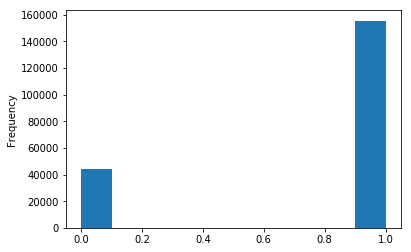

In [31]:
df_processed["loan_status"].plot(kind="hist")

Plotting correlation matrix for numerical variables:

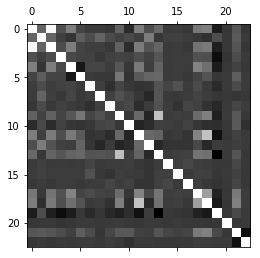

In [32]:
plt.matshow(df_processed[num_vars].corr(),cmap='gray')
plt.show()

## 3. Modelling

Getting response variable:

In [33]:
y=df_processed["loan_status"]
df_processed.drop(labels=["loan_status"],axis=1, inplace=True)

Casting dataframe into float:

In [34]:
df_processed = df_processed.astype(dtype="float64")
df_processed.dtypes

loan_amnt                      float64
int_rate                       float64
installment                    float64
emp_length                     float64
annual_inc                     float64
dti                            float64
delinq_2yrs                    float64
inq_last_6mths                 float64
mths_since_last_delinq         float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
collections_12_mths_ex_med     float64
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
total_rev_hi_lim               float64
tot_cur_bal_NA                 float64
tot_coll_amt_NA                float64
total_rev_hi_lim_NA            float64
mths_since_last_delinq_NA      float64
earliest_cr_line_year          float64
earliest_cr_line_month         float64
issue_d_year             

Inverting classes of response variable for further interpretation proposes:

In [35]:
y=1-y

Splitting into the train and test sets:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_processed,y,test_size=0.3, random_state=30, stratify=y)

Undersampling on train set:

In [37]:
def samp(y,rat):
    pos_ind=y[y==1].index
    n = pos_ind.shape[0]
    neg_ind= y[y==0].sample(n=int(n*rat)).index
    return pos_ind.append(neg_ind)


In [38]:
samp_ind=samp(y_train,1)

Log regression pipeline with Grid Search:

In [39]:
lr_steps = [('scaler', StandardScaler()), ('logit_reg', LogisticRegression(solver="lbfgs"))]
pl_lr = Pipeline(lr_steps) # define the pipeline object.

lr_params = {'logit_reg__C': [1e-07*(10**i) for i in range(1,9,1)], 'logit_reg__penalty':["l2"]}

lr = GridSearchCV(pl_lr, lr_params, cv=5)
lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logit_reg__C': [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.09999999999999999, 1.0, 10.0], 'logit_reg__penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print(lr.best_params_ )
print(lr.best_score_  )


{'logit_reg__C': 10.0, 'logit_reg__penalty': 'l2'}
0.7817533733829548


Log regression pipeline with Grid Search on undersampled dataset:

In [41]:
lr_samp = GridSearchCV(pl_lr, lr_params, cv=5)
lr_samp.fit(X_train.loc[samp_ind],y_train.loc[samp_ind])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logit_reg__C': [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.09999999999999999, 1.0, 10.0], 'logit_reg__penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
print(lr_samp.best_params_ )
print(lr_samp.best_score_  )

{'logit_reg__C': 0.01, 'logit_reg__penalty': 'l2'}
0.655822467724324


Gradient boosting pipeline with Grid Search:

In [43]:
gbm_steps = [('scaler', StandardScaler()), ('gbm', GradientBoostingClassifier())]
pl_gbm = Pipeline(gbm_steps) # define the pipeline object.
#gbm_params = {'gbm__learning_rate': [1e-04*(10**i) for i in range(1,5,1)], 'gbm__n_estimators':[i for i in range(20,160,20)]}
gbm_params = {'gbm__learning_rate': [0.1], 'gbm__n_estimators':[100]}
gbm = GridSearchCV(pl_gbm, gbm_params, cv=3)
gbm.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gbm__learning_rate': [0.1], 'gbm__n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## 4. Model selection

In [44]:
def get_thr(y_test, test_probs,thr): 
    t=tpr-fpr
    ind=np.argmax(t[tpr>=thr])
    return threshold[ind]

In [45]:
def plot_roc(y_test, test_probs,tit):
    fpr, tpr, threshold=roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(tit)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


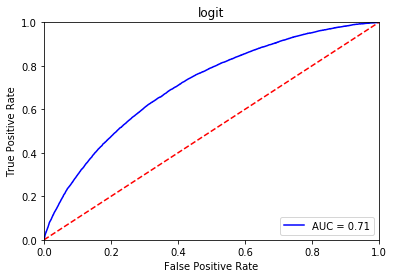

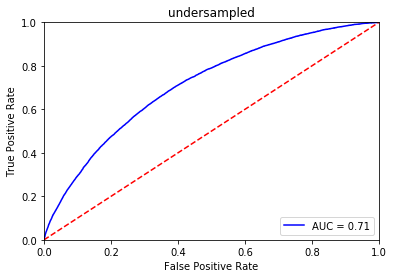

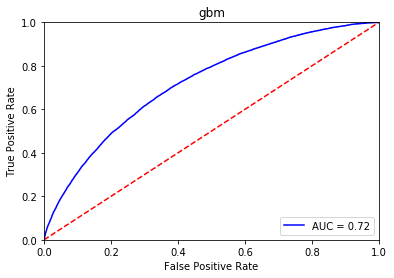

In [46]:
gbm_probs=gbm.predict_proba(X_test)[:,1]
lr_probs=lr.predict_proba(X_test)[:,1]
samp_probs=lr_samp.predict_proba(X_test)[:,1]
probs_arr=[lr_probs,samp_probs,gbm_probs]
nms=["logit","undersampled","gbm"]
for ind,i in enumerate(probs_arr):
    plot_roc(y_test, i,nms[ind])